In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy


In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
(training_set, validation_set), info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info = True,
    as_supervised = True,
)

In [4]:
num_classes = info.features['label'].num_classes
num_training_examples = 0 
num_validation_examples = 0

for examples in training_set:
  num_training_examples+=1

for examples in validation_set:
  num_validation_examples+=1

print('Total number of classes: ', num_classes)
print('Total number of training images: ', num_training_examples)
print('Total number of validation images: ', num_validation_examples)

Total number of classes:  5
Total number of training images:  2569
Total number of validation images:  1101


In [5]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [6]:
image_res = 224

def format_image(image, label):
  image = tf.image.resize(image, (image_res, image_res))/255.0
  return image, label

BATCH_SIZE = 32
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [7]:
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extractor = hub.KerasLayer(
    URL,
    input_shape= (image_res, image_res, 3))

In [8]:
feature_extractor.trainable = False

In [13]:
model = Sequential([
        feature_extractor,
        layers.Dense(5)
])

model.summary

<bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f9d2332eeb8>>

In [14]:
model.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 129s 2s/step - loss: 0.8162 - accuracy: 0.6855 - val_loss: 0.4636 - val_accuracy: 0.8383
Epoch 2/6
81/81 [==============================] - 126s 2s/step - loss: 0.3969 - accuracy: 0.8603 - val_loss: 0.3660 - val_accuracy: 0.8728
Epoch 3/6
81/81 [==============================] - 131s 2s/step - loss: 0.3070 - accuracy: 0.9031 - val_loss: 0.3262 - val_accuracy: 0.8847
Epoch 4/6
81/81 [==============================] - 125s 2s/step - loss: 0.2541 - accuracy: 0.9237 - val_loss: 0.3037 - val_accuracy: 0.8946
Epoch 5/6
81/81 [==============================] - 124s 2s/step - loss: 0.2176 - accuracy: 0.9369 - val_loss: 0.2986 - val_accuracy: 0.8983
Epoch 6/6
81/81 [==============================] - 126s 2s/step - loss: 0.1951 - accuracy: 0.9443 - val_loss: 0.2895 - val_accuracy: 0.9028


Text(0.5, 1.0, 'Training and Validation loss')

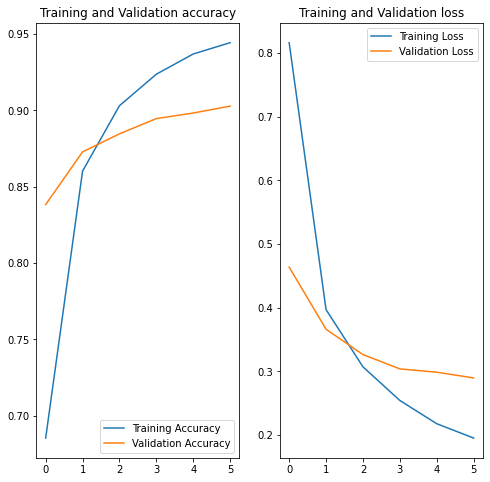

In [17]:
acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

In [22]:
class_names = np.array(info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [27]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batches = model.predict(image_batch)
predicted_batches = tf.squeeze(predicted_batches).numpy()

predicted_ids = np.argmax(predicted_batches, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['tulips' 'sunflowers' 'tulips' 'sunflowers' 'roses' 'tulips' 'tulips'
 'dandelion' 'dandelion' 'dandelion' 'roses' 'daisy' 'roses' 'daisy'
 'sunflowers' 'tulips' 'roses' 'dandelion' 'tulips' 'daisy' 'daisy'
 'tulips' 'roses' 'daisy' 'roses' 'daisy' 'sunflowers' 'tulips' 'tulips'
 'sunflowers' 'dandelion' 'daisy']


In [29]:
print('Predicted labels : ', predicted_class_names)
print('True labels : ', class_names[label_batch])

Predicted labels :  ['tulips' 'sunflowers' 'tulips' 'sunflowers' 'roses' 'tulips' 'tulips'
 'dandelion' 'dandelion' 'dandelion' 'roses' 'daisy' 'roses' 'daisy'
 'sunflowers' 'tulips' 'roses' 'dandelion' 'tulips' 'daisy' 'daisy'
 'tulips' 'roses' 'daisy' 'roses' 'daisy' 'sunflowers' 'tulips' 'tulips'
 'sunflowers' 'dandelion' 'daisy']
True labels :  ['tulips' 'sunflowers' 'tulips' 'sunflowers' 'roses' 'tulips' 'tulips'
 'dandelion' 'dandelion' 'dandelion' 'roses' 'daisy' 'roses' 'daisy'
 'sunflowers' 'tulips' 'roses' 'roses' 'tulips' 'daisy' 'daisy' 'tulips'
 'roses' 'dandelion' 'roses' 'daisy' 'sunflowers' 'tulips' 'tulips'
 'roses' 'dandelion' 'daisy']


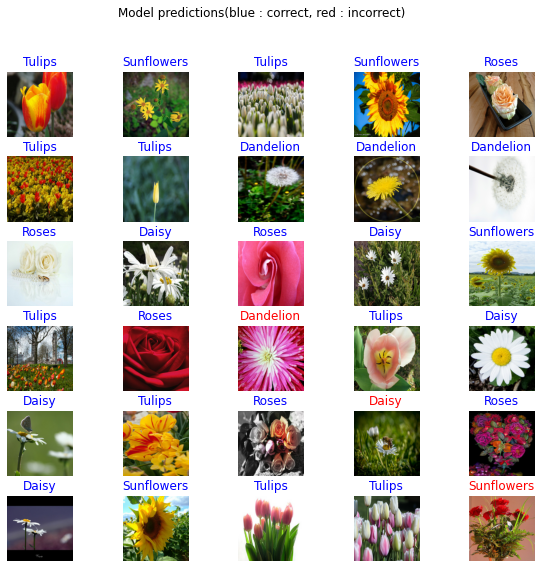

In [31]:
plt.figure(figsize=(10,9))

for n in range(6*5):
  plt.subplot(6, 5, n+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(image_batch[n])
  color = 'blue' if predicted_ids[n] == label_batch[n] else 'red'
  plt.title(predicted_class_names[n].title(), color = color)
  plt.axis('off')
  _= plt.suptitle('Model predictions(blue : correct, red : incorrect)')



In [36]:
image_res = 299

(training_data, validation_data), info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info = True,
    as_supervised=True,
)


training_batch = training_data.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batch = validation_data.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(
    URL,
    input_shape = (image_res, image_res, 3),
    trainable=False
)

model_inception = Sequential([
                feature_extractor,
                layers.Dense(5)
])


In [38]:
model_inception.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']  
)

history = model_inception.fit(
    training_batch,
    epochs=EPOCHS,
    validation_data=validation_batch
)

Epoch 1/6
81/81 [==============================] - ETA: 0s - loss: 0.7595 - accuracy: 0.7279

ValueError: ignored

In [30]:
for n in range(30):
  print(n)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
